# Initialization

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from result_saver import SaverProvider

provider = SaverProvider()

# Initialize simulator

In [20]:
from soft_info import RepCodeIQSimulator

DEVICE = 'ibm_sherbrooke'
DISTANCE = 7
ROUNDS = 7
OTHER_DATE = '2021-11-11'
_RESETS = False
LOGICAL = 0 # NOT NEEDED FOR EXTREME IQ BCS HARDCODED 0

_is_hex = True
if DEVICE == 'ibmq_mumbai':
    _is_hex = False

# Initialize simulator
simulator = RepCodeIQSimulator(provider, DISTANCE, ROUNDS, DEVICE, _is_hex=_is_hex, _resets = _RESETS, other_date=OTHER_DATE)

# Get IQ data

In [21]:
SHOTS = int(1e4)
NOISE_LIST = [3e-2, 0.8e-2, 1e-2, 3e-2] # [two-qubit-fidelity, reset error, measurement error, idle error]
# NOISE_LIST = None
P_AMBIG = 0.3

IQ_data= simulator.generate_IQ(SHOTS, noise_list=NOISE_LIST)
IQ_data_extreme = simulator.generate_extreme_IQ(SHOTS, P_AMBIG, noise_list=NOISE_LIST)

100%|██████████| 8871/8871 [00:03<00:00, 2646.08it/s]


# Pickle for other applications

In [22]:
import pickle

with open('IQ_data.pkl', 'wb') as f:
    pickle.dump(IQ_data, f)

with open('IQ_data_extreme.pkl', 'wb') as f:
    pickle.dump(IQ_data_extreme, f)

with open('qubit_mapping.pkl', 'wb') as f:
    pickle.dump(simulator.qubit_mapping, f)

with open('stim_circ.pkl', 'wb') as f:
    pickle.dump(simulator.stim_circ, f)

# Simulator

# Decode IQ data

In [23]:
import pymatching
import stim

model = simulator.stim_circ.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)

In [24]:
import cpp_soft_info
from Scratch import load_calibration_memory

bandwiths = [0.2]*127
all_memories = load_calibration_memory(provider, tobecalib_backend=DEVICE, other_date=OTHER_DATE)
kde_dict = cpp_soft_info.get_KDEs(all_memories, bandwiths)

Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.


# Using cpp kde

In [25]:
_DETAILED = True

matching = pymatching.Matching.from_detector_error_model(model)
result = cpp_soft_info.decode_IQ_shots(matching._matching_graph, IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                           common_measure=-1, _adv_probs=not _RESETS, _bimodal=_RESETS, merge_strategy = "replace", _detailed=_DETAILED,
                                            p_offset = 1, p_multiplicator = 1, _ntnn_edges = not _RESETS)

matching = pymatching.Matching.from_detector_error_model(model)
result_extreme = cpp_soft_info.decode_IQ_shots(matching._matching_graph, IQ_data_extreme,
                                             ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                             simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                             common_measure=-1, _adv_probs=not _RESETS, _bimodal=_RESETS, merge_strategy = "replace", _detailed=_DETAILED,
                                              p_offset = 1, p_multiplicator = 1, _ntnn_edges = not _RESETS)

print("num_errors IQ:", result.num_errors, "out of", len(IQ_data), "shots for _RESETS =", _RESETS)
print("num_errors IQ EXTREME:", result_extreme.num_errors, "out of", len(IQ_data_extreme), "shots for _RESETS =", _RESETS)

num_errors: 132 out of 10000 shots for _RESETS = False
num_errors EXTREME: 272 out of 10000 shots for _RESETS = False


In [26]:
result_kde = cpp_soft_info.decode_IQ_kde(model, IQ_data, ROUNDS, int(LOGICAL), _RESETS, 
                                         simulator.qubit_mapping, kde_dict, _DETAILED)

result_extreme_kde = cpp_soft_info.decode_IQ_kde(model, IQ_data_extreme, ROUNDS, int(LOGICAL), _RESETS,
                                            simulator.qubit_mapping, kde_dict, _DETAILED)

print("num_errors KDE:", result_kde.num_errors, "out of", len(IQ_data), "shots for _RESETS =", _RESETS)
print("num_errors KDE EXTREME:", result_extreme_kde.num_errors, "out of", len(IQ_data_extreme), "shots for _RESETS =", _RESETS)

num_errors KDE: 324 out of 10000 shots for _RESETS = False
num_errors EXTREME KDE: 589 out of 10000 shots for _RESETS = False


In [27]:
p_meas = -1
# p_meas = 30e-2 

matching = pymatching.Matching.from_detector_error_model(model)
result_informed = cpp_soft_info.decode_IQ_shots_flat_informed(matching._matching_graph, IQ_data[:],
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict,
                                           p_data = -1, p_mixed = -1, p_meas = p_meas, common_measure=-1, _detailed=_DETAILED, _ntnn_edges = True)

matching = pymatching.Matching.from_detector_error_model(model)
result_informed_extreme = cpp_soft_info.decode_IQ_shots_flat_informed(matching._matching_graph, IQ_data_extreme[:],
                                             ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict,
                                             p_data = -1, p_mixed = -1, p_meas = p_meas, common_measure=-1, _detailed=_DETAILED, _ntnn_edges = True)

print("num_errors informed:", result_informed.num_errors, "out of", len(IQ_data), "shots for _RESETS =", _RESETS)
print("num_errors informed EXTREME:", result_informed_extreme.num_errors, "out of", len(IQ_data_extreme), "shots for _RESETS =", _RESETS)
         
# takes 1s

num_errors informed: 166 out of 10000 shots for _RESETS = False
num_errors informed EXTREME: 2394 out of 10000 shots for _RESETS = False


In [29]:
matching = pymatching.Matching.from_detector_error_model(model)
result_flat = cpp_soft_info.decode_IQ_shots_flat(matching._matching_graph, IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, _detailed=_DETAILED)

matching = pymatching.Matching.from_detector_error_model(model)
result_flat_extreme = cpp_soft_info.decode_IQ_shots_flat(matching._matching_graph, IQ_data_extreme,
                                                         ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                                            simulator.processed_scaler_dict, _detailed=_DETAILED)

print("num_errors:", result_flat.num_errors, "out of", len(IQ_data), "shots for _RESETS =", _RESETS)
print("num_errors EXTREME:", result_flat_extreme.num_errors, "out of", len(IQ_data_extreme), "shots for _RESETS =", _RESETS)

num_errors: 196 out of 10000 shots for _RESETS = False
num_errors EXTREME: 3732 out of 10000 shots for _RESETS = False


# Plot the results

In [32]:
print("\nIQ:", result.indices, "\nFlat:", result_flat.indices, "\nInformed", result_informed.indices)
print("\nIQ EXTREME:", result_extreme.indices, "\nFlat EXTREME:", result_flat_extreme.indices, "\nInformed EXTREME", result_informed_extreme.indices)


IQ: [3, 5, 6, 7] 
Flat: [3, 5, 7] 
Informed [3, 5, 6, 7, 9]

IQ EXTREME: [5, 6, 8] 
Flat EXTREME: [4, 5, 6, 8] 
Informed EXTREME [5, 6, 9]


-----IQ True decoding -----
Drawing graph...


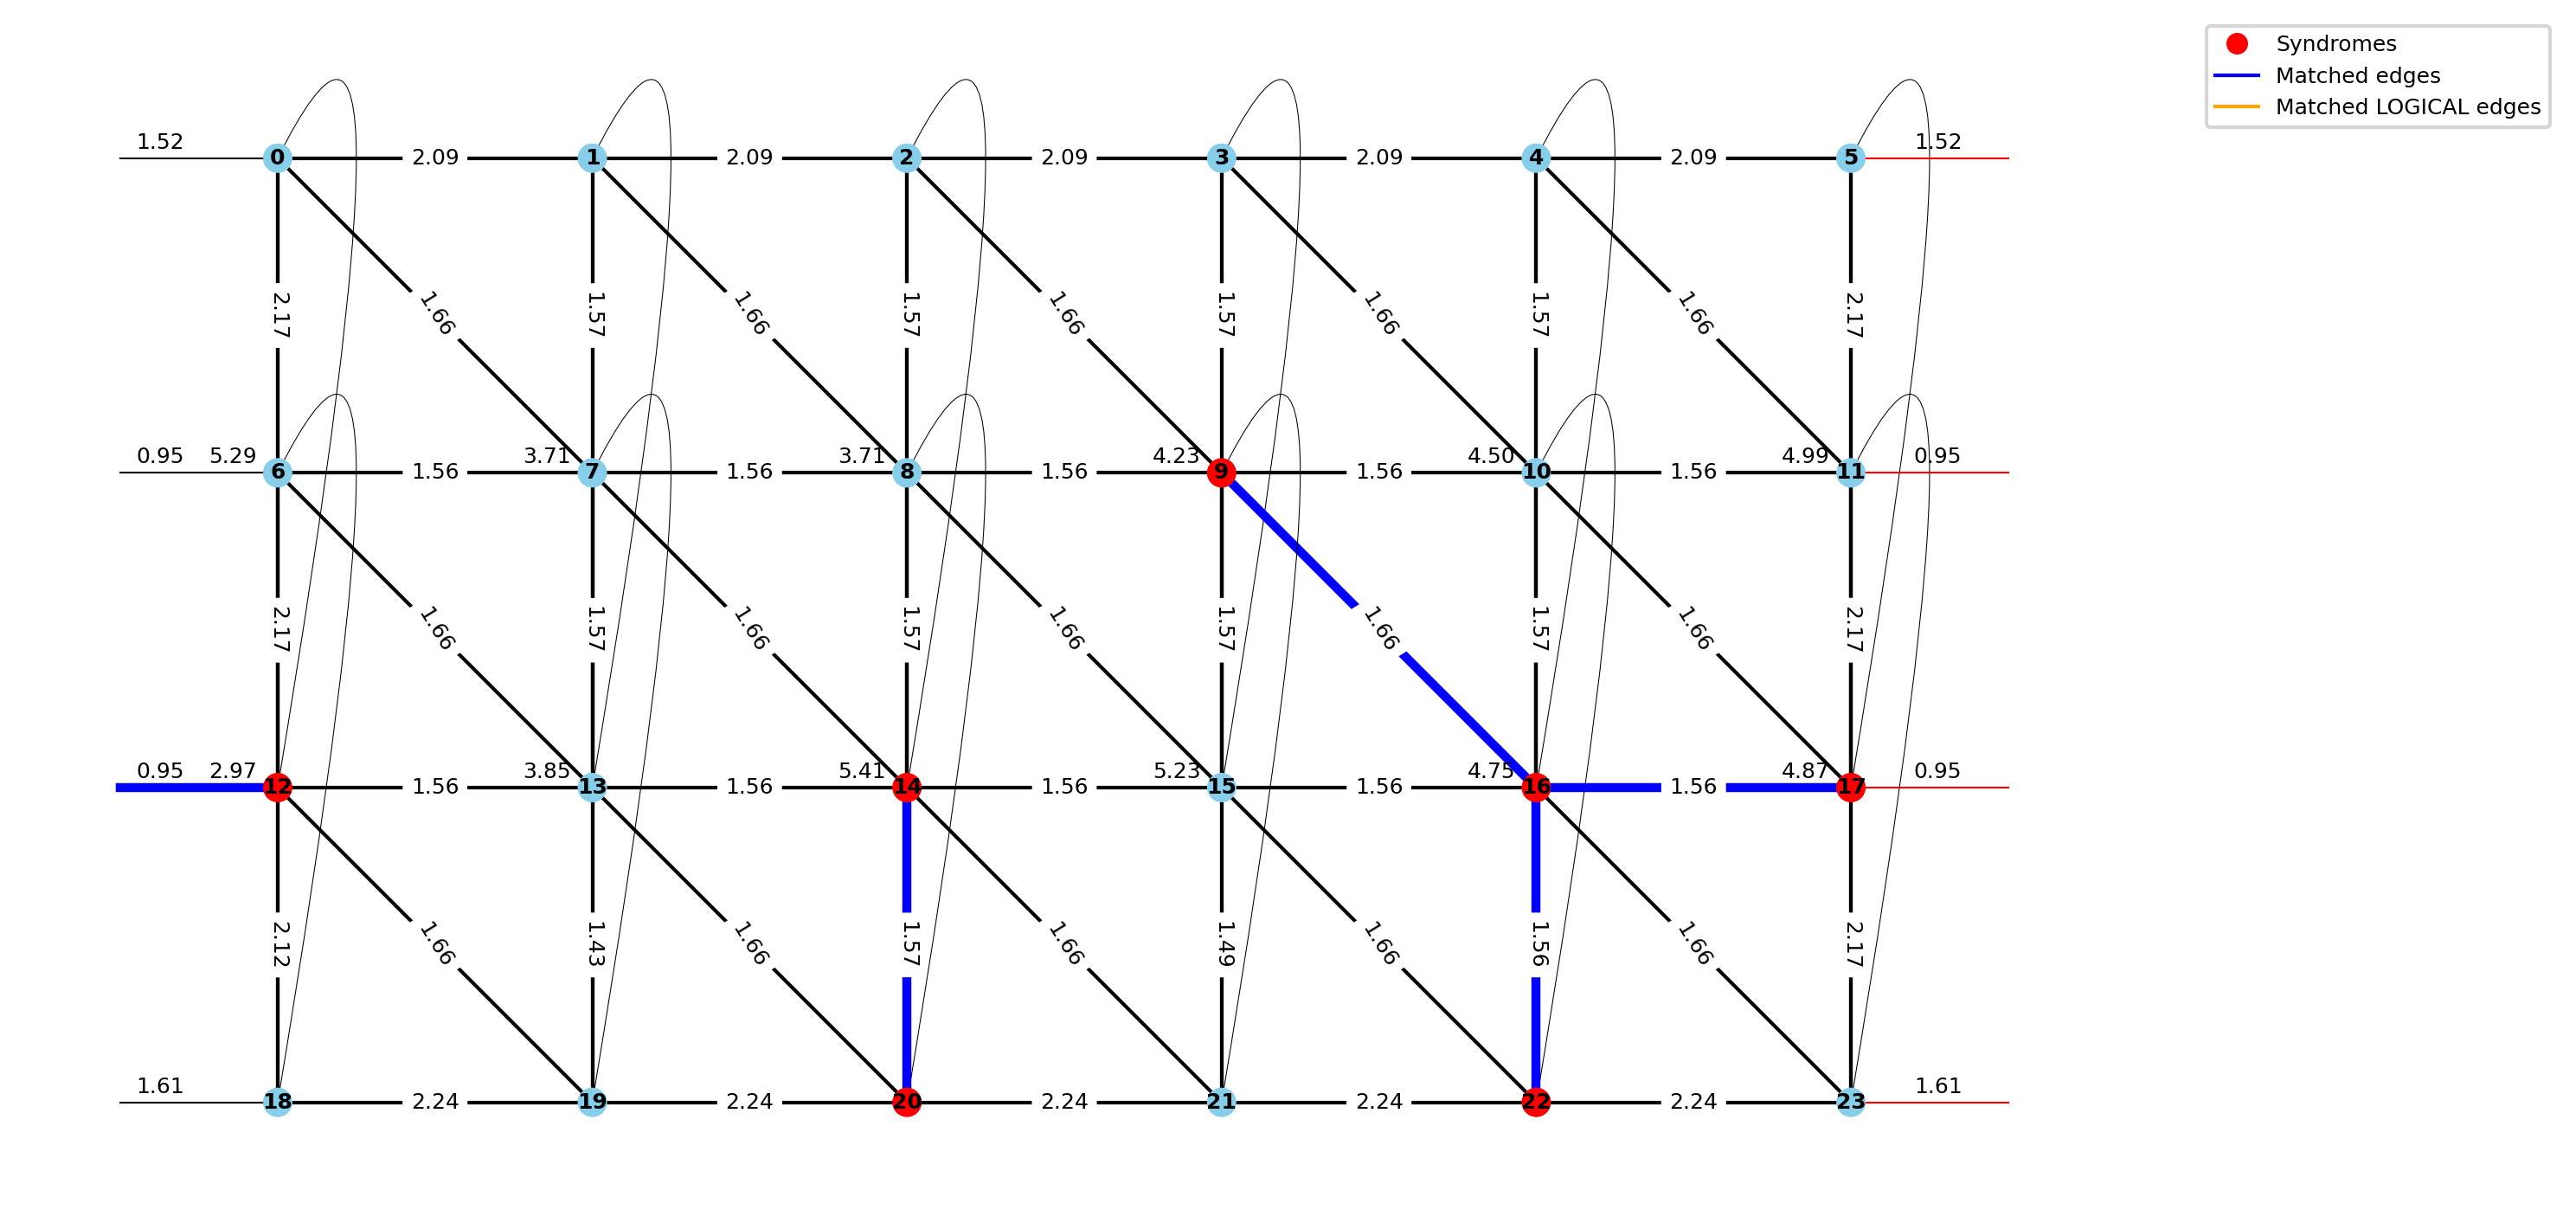

-----flat True decoding-----
Drawing graph...


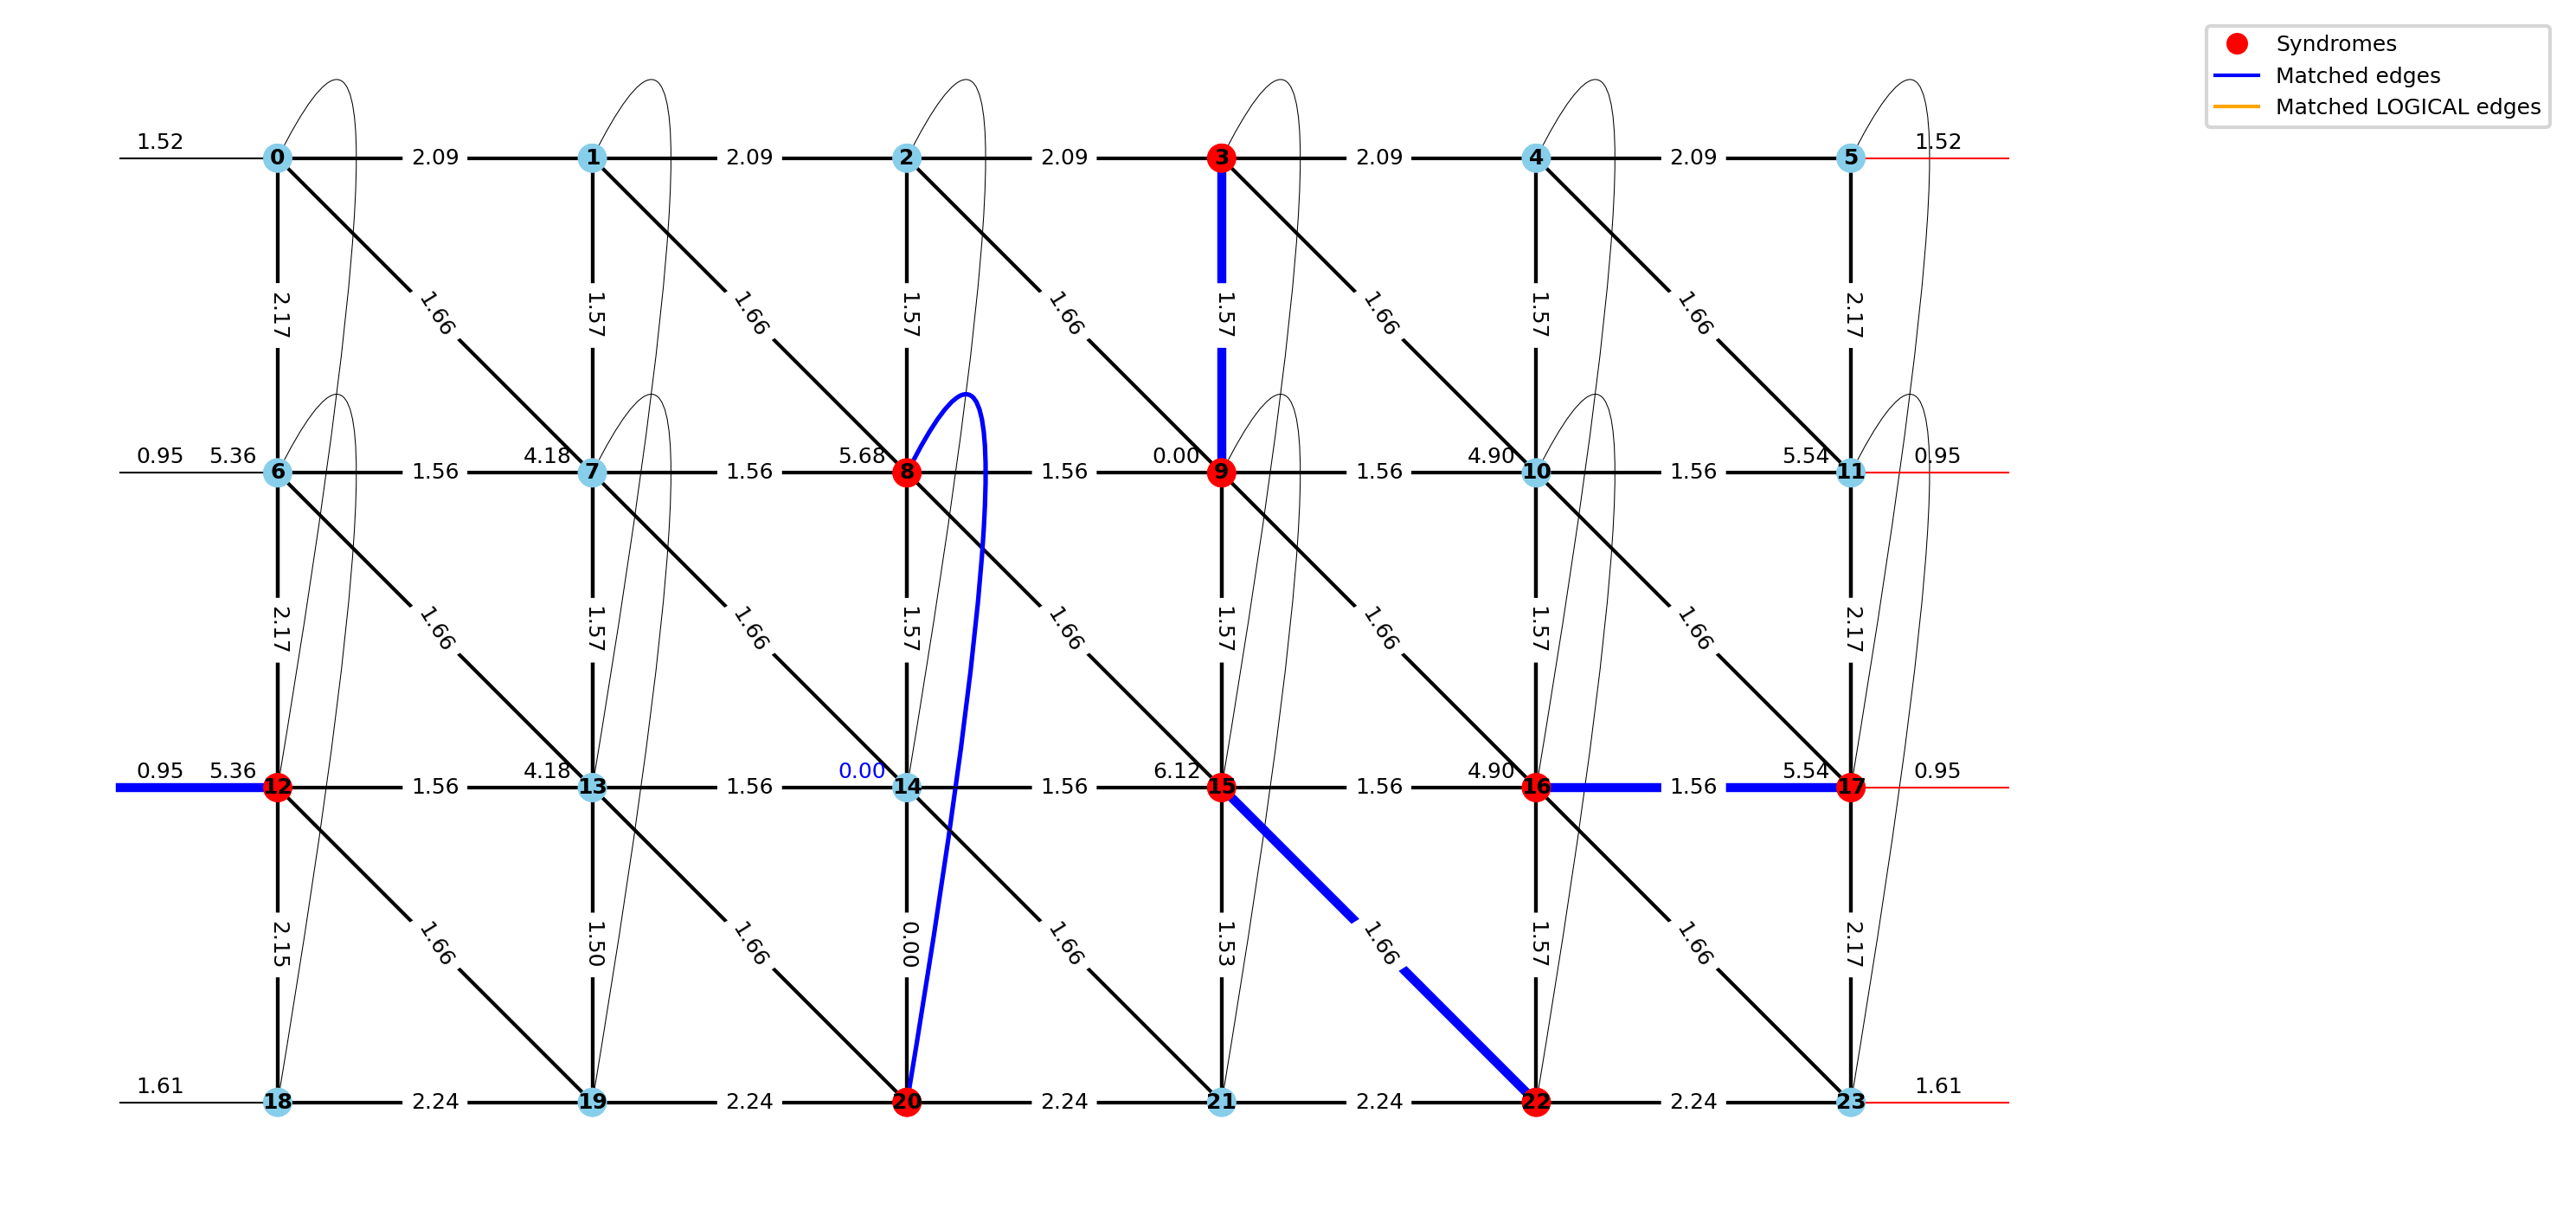

-----INFORMED True decoding-----
Drawing graph...


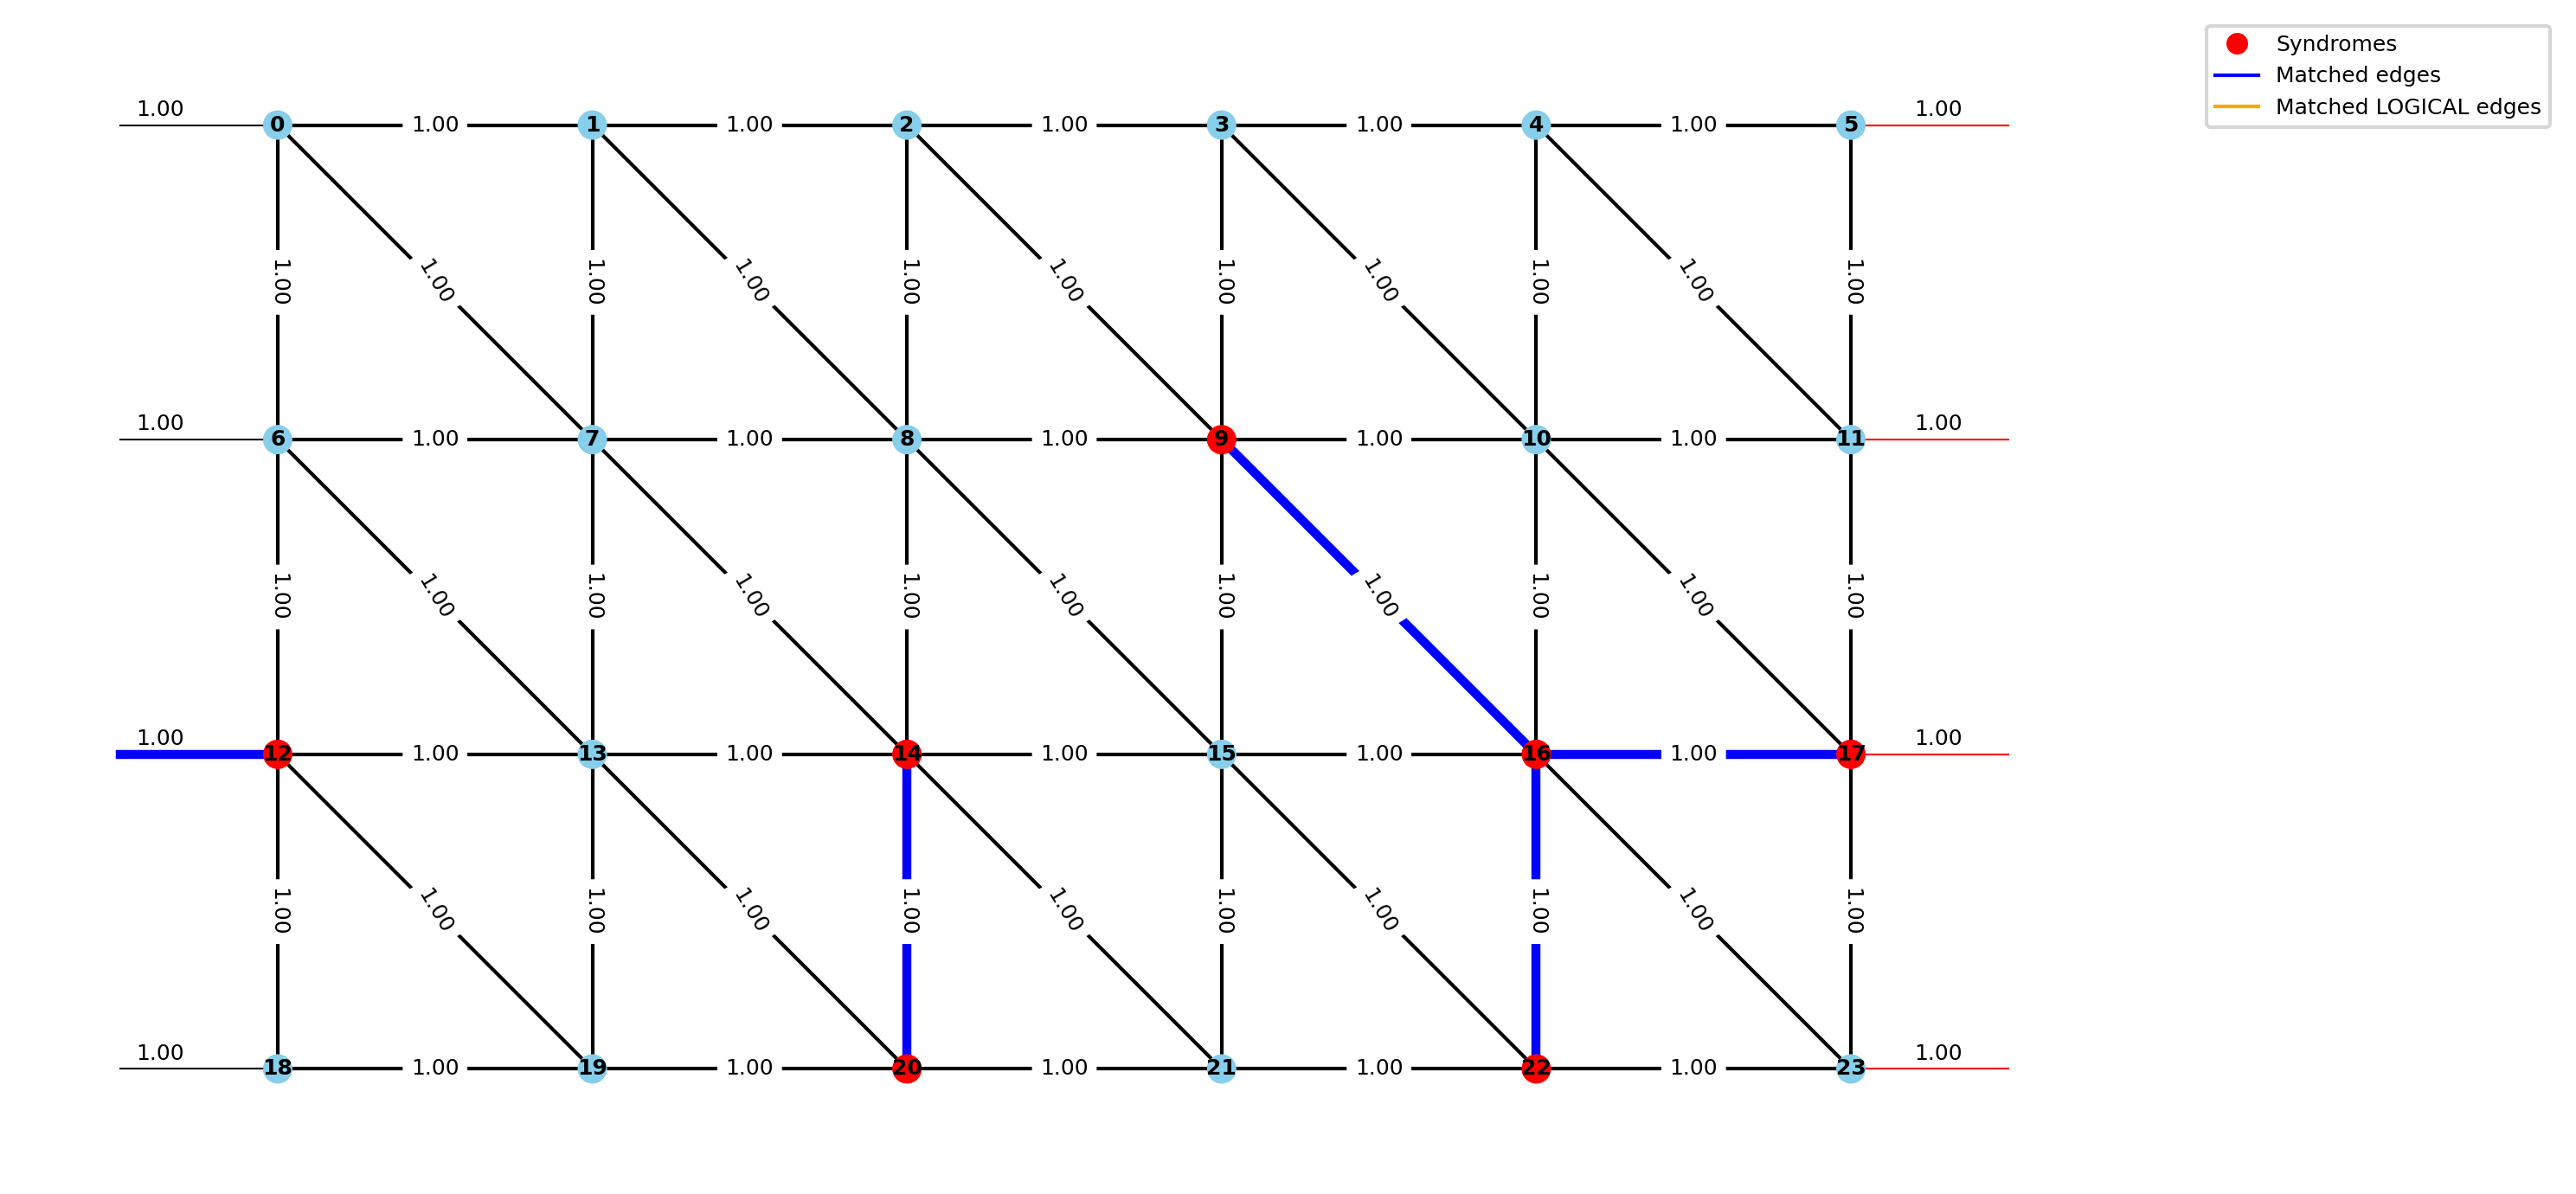

In [34]:
from soft_info import draw_matching_graph


index = 2

fig_size = (4, 13)
fig_size = (8, 8)
scale_factor = 0.5

to_be_result = result
details = to_be_result.error_details[index]
print(f"-----IQ {bool(not (index in to_be_result.indices))} decoding -----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_extreme
details = to_be_result.error_details[index]
print(f"-----flat {bool(not (index in to_be_result.indices))} decoding-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_flat
details = to_be_result.error_details[index]
print(f"-----INFORMED {bool(not (index in to_be_result.indices))} decoding-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)


In [24]:
informed_not_in_iq = sorted(set(result_informed.indices) - set(result.indices))
print("indices that are in informed but not in IQ with len:", len(informed_not_in_iq))
print(informed_not_in_iq)
iq_not_in_informed = sorted(set(result.indices) - set(result_informed.indices))
print("indices that are in IQ but not in informed with len:", len(iq_not_in_informed))
print(iq_not_in_informed)

print()

iq_not_in_flat = sorted(set(result.indices) - set(result_flat.indices))
print("indices that are in IQ but not in flat with len:", len(iq_not_in_flat))
print(iq_not_in_flat)
flat_not_in_iq = sorted(set(result_flat.indices) - set(result.indices))
print("indices that are in flat but not in IQ with len:", len(flat_not_in_iq))
print(flat_not_in_iq)

indices that are in informed but not in IQ with len: 0
[]
indices that are in IQ but not in informed with len: 0
[]

indices that are in IQ but not in flat with len: 0
[]
indices that are in flat but not in IQ with len: 0
[]


# Analyse specific shots

{'0000000 000001 000000 001000 001000 000000 000000 000000': 1}


100%|██████████| 169/169 [00:00<00:00, 2354941.45it/s]

mean time edge weight: 3.1121797526416013

[(2, 14), (5, 17), (19, 7), (12, -1), (11, 23), (33, 21), (33, 45), (27, 39), (34, 35), (36, 37), (38, 44)]
-----IQ-----


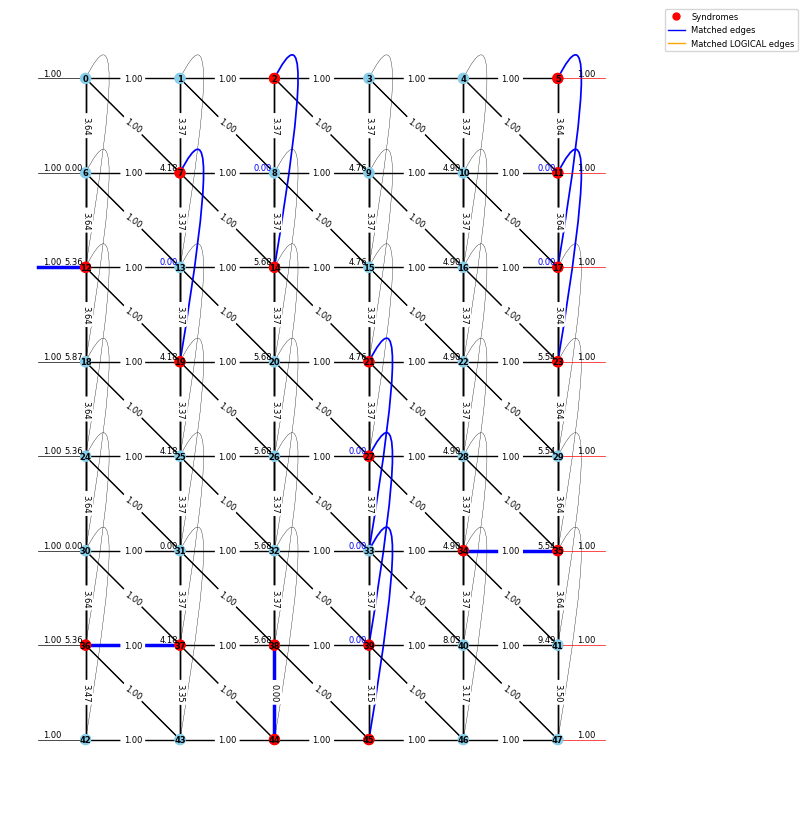

In [ ]:
from tqdm import tqdm

index = 83
IQ_data_new = IQ_data[index:index+1]

esult = cpp_soft_info.decode_IQ_shots(matching._matching_graph, IQ_data_extreme,
                                             ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                             simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                             common_measure=-1, _adv_probs=not _RESETS, _bimodal=_RESETS, merge_strategy = "replace", _detailed=_DETAILED,
                                              p_offset = 1, p_multiplicator = 1, _ntnn_edges = True)

print(cpp_soft_info.get_counts(IQ_data_new, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict, ROUNDS))



to_be_result = esult
details = to_be_result.error_details[0]


mean_edge_weight = 0
num_time_edges = 0
for edge in tqdm(matching.edges()):
    src_node, tgt_node, data = edge
    if src_node == None or tgt_node == None:
        continue
    if src_node == tgt_node - (DISTANCE-1):
        mean_edge_weight += data["weight"]
        num_time_edges += 1

print("mean time edge weight:", mean_edge_weight / num_time_edges)

print()
print(details.matched_edges)

print("-----IQ-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)